In [2]:
# importing the libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
# loading the data into a data frame and checking the columns
sales = pd.read_excel('C:/Users/anuj.gulati/Desktop/RFM/online_retail.xlsx')
sales.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
# output number of rows and columns
print('{:,} rows; {:,} columns'.format(sales.shape[0], sales.shape[1]))

541,909 rows; 8 columns


In [7]:
# checking the data in the sales data frame
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
# checking if there is null in the customer id
print('{:,} invoices don\'t have a customer id'.format(sales[sales.CustomerID.isnull()].shape[0]))

135,080 invoices don't have a customer id


In [11]:
# dropping rows with no customer id
sales.dropna(subset=['CustomerID'], inplace=True)

In [13]:
# checking data frame after dropping nulls in the customer id
print('{:,} rows; {:,} columns'.format(sales.shape[0], sales.shape[1]))

406,829 rows; 8 columns


In [15]:
# checking the time frame of the data frame
print('Orders from {} to {}'.format(sales['InvoiceDate'].min(),
                                    sales['InvoiceDate'].max()))

Orders from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [19]:
# in order to perform RFM analysis, we will calculate the total price 
sales['Price'] = sales['Quantity'] * sales['UnitPrice']
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [20]:
# in RFM we care for how many times a customer purchases. we need to group the data by invoice number, invoice date & customer id. 
orders = sales.groupby(['InvoiceNo', 'InvoiceDate', 'CustomerID']).agg({'Price': lambda x: x.sum()}).reset_index()
orders.head()

,InvoiceNo,InvoiceDate,CustomerID,Price
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


In [22]:
# as RFM analysis done in real time by setting "NOW" with a date which is one day after the max date of the dateset. 
NOW = orders['InvoiceDate'].max() + timedelta(days=1)
NOW

Timestamp('2011-12-10 12:50:00')

In [24]:
# as the dataset if for slightly more than an year, we will be restricting the dataset for 365 days using "PERIOD"
period = 365


In [26]:
# to calculate the recency of each order, we will add another column to see the days between "NOW" and invoice date for each customer
orders['DaysSinceOrder'] = orders['InvoiceDate'].apply(lambda x: (NOW - x).days)

In [30]:
orders.head()

,InvoiceNo,InvoiceDate,CustomerID,Price,DaysSinceOrder
0,536365,2010-12-01 08:26:00,17850.0,139.12,374
1,536366,2010-12-01 08:28:00,17850.0,22.20,374
2,536367,2010-12-01 08:34:00,13047.0,278.73,374
3,536368,2010-12-01 08:34:00,13047.0,70.05,374
4,536369,2010-12-01 08:35:00,13047.0,17.85,374


In [32]:
# calculating the frequency and recency of each customer
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'InvoiceDate': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency
0,12346.0,326,2
1,12347.0,2,6
2,12348.0,75,4
3,12349.0,19,1
4,12350.0,310,1


In [33]:
# calculating the monetary value for each customer
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: orders[(orders['CustomerID'] == x) & \
                                                           (orders['InvoiceDate'] >= NOW - timedelta(days=period))]\
                                                           ['Price'].sum())
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,6,3598.21
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [35]:
# calculating the RFM scores. each customer will get a score between 1-5 based on Recency, Frequency & Monetary columns. 
# one way to do is to create buckets for each of those manually or it can be done using quantiles function of python 
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles


{'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
 'Monetary': {0.2: 215.89800000000002,
  0.4: 440.432,
  0.6: 876.3679999999999,
  0.8: 1909.6580000000006},
 'Recency': {0.2: 11.0, 0.4: 32.0, 0.6: 71.0, 0.8: 178.80000000000018}}

In [40]:
# defining functions for Recency, Frequency & Monetary Scores
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [41]:
# applying the function defined above on our dataset
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [43]:
# combining the 3 scores together
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,6,3598.21,5,4,5,545
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [45]:
# RFM score can have 5^3 = 125 possible segments. limiting it to 11 different segments to keep it manageable
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,2,0.00,1,2,1,121,hibernating
1,12347.0,2,6,3598.21,5,4,5,545,champions
2,12348.0,75,4,1797.24,2,4,4,244,at risk
3,12349.0,19,1,1757.55,4,1,4,414,promising
4,12350.0,310,1,334.40,1,1,2,112,hibernating


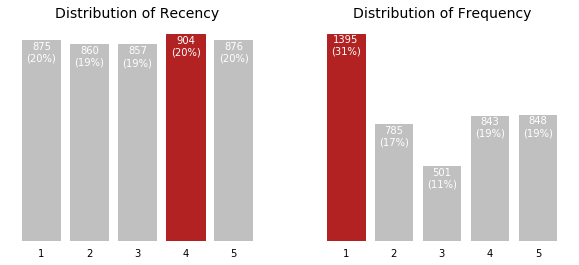

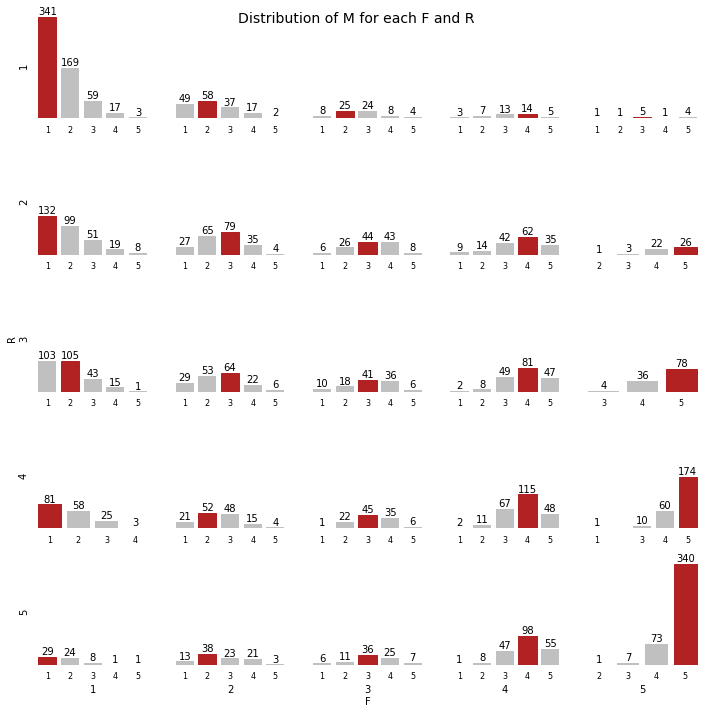

In [47]:
# visualizing the segments 
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

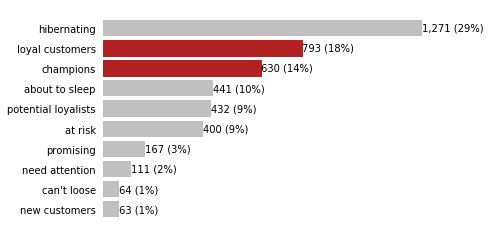

In [48]:
#We can see that if recency seems to be evenly distributed, almost half of the customers don't purchase 
#very often (48% of customers have a frequency of 1 or 2).

#When looking at the monetary value, we see that the customers spending the most are those with the 
#highest activity (R and F of 4-5). We have very few large orders (high monetary value but low frequency).

#Let's look at the distribution of our segments.





# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()



#We have a lot of customers who don't buy frequently from us (29% are hibernating)
#However, 32% of our customers are either champions or loyal customers

